In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random

2024-11-12 22:05:58.390040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 22:05:58.390764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 22:05:58.392835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 22:05:58.397933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731445558.406289 1105259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731445558.40

## Classification Model

In [13]:
random.seed(237817)

# Setting these as global variables so that they can be shuffled to ensure an even distribution- many times I wasn't getting all 24/720 labels in the validation set

images = np.load("75/images.npy")
labels = np.load("75/labels.npy")

size = 75
images = np.load(f'{size}/images.npy')
total = 18000
split = int(total*0.8)

indices = np.random.permutation(images.shape[0])
shuffled_images = images[indices,:,:]
shuffled_labels = labels[indices,:]

train_images = shuffled_images[0:split,:,:]
train_labels = shuffled_labels[0:split,:]

test_images = shuffled_images[split:,:,:]
test_labels = shuffled_labels[split:,:]

valid_images = train_images[0:500,:,:]
valid_labels = train_labels[0:500,:]

train_images = train_images[500:,:,:]
train_labels = train_labels[500:,:]

train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

train_images= train_images.reshape(train_images.shape[0],75,75,1)
test_images  = test_images.reshape(test_images.shape[0],75,75,1)
valid_images = valid_images.reshape(valid_images.shape[0],75,75,1)

train_labels = train_labels.astype("float32")
test_labels = test_labels.astype("float32")
valid_labels = valid_labels.astype("float32")

train_hours = train_labels[:,0]
train_minutes = train_labels[:,1] / 60.0
test_hours = test_labels[:,0]
test_minutes = test_labels[:,1] / 60.0
valid_hours = valid_labels[:,0] 
valid_minutes = valid_labels[:,1] / 60.0

# Convert the time into 24 separate labels
def conv_time_24(hours, minutes):
    h, m = int, float
    if minutes <= .50:
        h = int(hours)
        m = 0.5
    else:
      m = 0
      h = int(hours)
    
    return h, m

# Convert the time into 720 separate labels 
def conv_time_720(time):
    return time[0]*60 + time[1]

conv_time = conv_time_24

y_train_converted = np.empty(13900, dtype=float)
y_test_converted = np.empty(3600, dtype=float)
y_valid_converted = np.empty(500, dtype=float)

for i in range(len(train_hours)):
    hours, minutes = conv_time(train_hours[i], train_minutes[i])
    y_train_converted[i] = hours + float(minutes)
    
for i in range(len(test_hours)):
    hours, minutes = conv_time(test_hours[i], test_minutes[i])
    y_test_converted[i] = hours + float(minutes) 
    
for i in range(len(valid_hours)):   
    hours, minutes = conv_time(valid_hours[i], valid_minutes[i])
    y_valid_converted[i] = hours + float(minutes)

encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test_converted)
y_train_encoded = encoder.fit_transform(y_train_converted)
y_valid_encoded = encoder.fit_transform(y_valid_converted)

OH_Encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = OH_Encoder.fit_transform(y_train_encoded.reshape(-1, 1))
onehot_encoded_valid = OH_Encoder.fit_transform(y_valid_encoded.reshape(-1, 1))

In [14]:
import tensorflow.keras.backend as K

#Common sense error function- checks the smaller of the differences by converting to military time
def common_sense_error(true, pred):
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

In [ ]:
np.random.seed(9999)


# Classification CNN
input_shape=(images.shape[1], images.shape[2], 1)
print(train_images.shape, onehot_encoded.shape, input_shape)

model_classification = tf.keras.models.Sequential()
model_classification.add(Input(shape=input_shape))
model_classification.add(Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model_classification.add(Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=input_shape))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))


model_classification.add(Flatten())
model_classification.add(Dense(units=1024, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=128, activation="relu"))
model_classification.add(Dense(units=64, activation="relu"))
model_classification.add(Dense(units=32, activation="relu"))
model_classification.add(Dense(units=24, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_classification.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

(13900, 75, 75, 1) (13900, 24) (75, 75, 1)


/vol/home/s4201388/Documents/Leiden/IDL/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
cl_h = model_classification.fit(train_images, onehot_encoded, epochs=50, batch_size=180, validation_data=(valid_images, onehot_encoded_valid), callbacks=[early_stop])

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0415 - loss: 3.1780 - val_accuracy: 0.0340 - val_loss: 3.1781
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0426 - loss: 3.1776 - val_accuracy: 0.0340 - val_loss: 3.1782
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0460 - loss: 3.1777 - val_accuracy: 0.0340 - val_loss: 3.1782
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0481 - loss: 3.1778 - val_accuracy: 0.0340 - val_loss: 3.1784
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0462 - loss: 3.1771 - val_accuracy: 0.0340 - val_loss: 3.1780
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0477 - loss: 3.1767 - val_accuracy: 0.0380 - val_loss: 3.1718
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0518 - loss: 3.1580 - val_accuracy: 0.0600 - val_loss: 3.1113
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0787 - loss: 3.0688 - val_accuracy: 0.0920 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


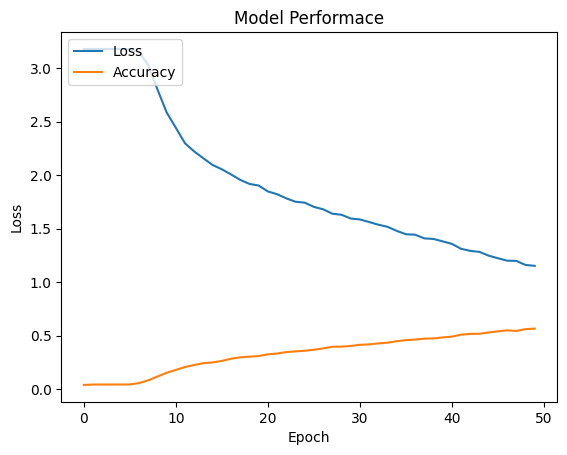

In [34]:
# Graph the model training
print(cl_h.history.keys())
plt.plot(cl_h.history['loss'])
plt.plot(cl_h.history['accuracy'])
plt.title('Model Performace')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')

In [35]:
# Measuring accuracy- picking the highest confidence label and comparing it to the true label
predicted = model_classification.predict(test_images)
predicted = np.argmax(predicted, axis=1)

print(np.sum(predicted == y_test_encoded) / len(y_test_encoded) * 100, "%")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
51.44444444444445 %


## Regression Model

In [ ]:
import tensorflow.keras.backend as K

#returning the common sense difference between two times
def common_sense_error(true, pred):
    true = K.cast(true, 'float32')
    diff_1 = K.abs(true - pred)
    diff_2 = K.abs(true - (pred + 12))

    return K.minimum(diff_1, diff_2)

In [ ]:
initialize()

# Convert the time into a continuous value
def conv_time(time):
    return round(time[0] + time[1]/60, 3)

train_labels_reg = np.array([conv_time(time) for time in train_labels])
test_labels_reg = np.array([conv_time(time) for time in test_labels])
val_labels_reg = np.array([conv_time(time) for time in val_labels])

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(activation='relu', filters=32, kernel_size=(3,3), input_shape=(75, 75, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=1, activation="softplus"))
model.compile(loss="mse", optimizer="adam", metrics=[common_sense_error])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

regression_model = model.fit(train_imgs, train_labels_reg, epochs=10, batch_size = 512, validation_data = (val_imgs, val_labels_reg), callbacks = [early_stop])

In [ ]:
# Measuring accuracy within 1 minute of the true time
reg_preds = model.predict(test_imgs)
accuracy = np.mean(abs(reg_preds - test_labels_reg) < 0.16)
print(accuracy*100, '%')

## Two-Headed Model

In [ ]:
initialize()

train_hours = train_labels[:, 0]
train_minutes = train_labels[:, 1]

val_hours = val_labels[:, 0]
val_minutes = val_labels[:, 1]

test_hours = test_labels[:, 0]
test_minutes = test_labels[:, 1]

train_minutes = train_minutes / 60
test_minutes = test_minutes / 60
val_minutes = val_minutes / 60

In [ ]:
import tensorflow.keras.backend as K

def common_sense_hour(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

def common_sense_minute(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+60-true)
    return K.minimum(diff1, diff2)

In [ ]:
inp = keras.layers.Input(shape = (75,75,1))
model = keras.layers.Convolution2D(32,kernel_size = (5,5), strides= (2,2), activation = "relu")(inp)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(32,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.MaxPooling2D(pool_size =2)(model)
model = keras.layers.Convolution2D(64,kernel_size = (3,3),activation = "relu")(model)
model = keras.layers.Convolution2D(64,kernel_size = (1,1),activation = "relu")(model)
model = keras.layers.Flatten()(model)

d = keras.layers.Dense(256,activation = "relu")(model)
d = keras.layers.Dense(256,activation = "relu")(d)
d = keras.layers.Dropout(0.1)(d)
d = keras.layers.Dense(256,activation = "relu")(d)

# The hour head predicts confidence amonst 12 label classes- one for each hour 
hour = keras.layers.Dense(256,activation = "relu")(d)
hour = keras.layers.Dense(128,activation = "relu")(hour)
hour = keras.layers.Dense(64,activation = "relu")(hour)
hour = keras.layers.Dense(32,activation = "relu")(hour)
hour = keras.layers.Dense(16,activation = "relu")(hour)
hour = keras.layers.Dense(12,activation= "softmax", name= "hour")(hour)

# The minute head runs a regression on a continuous value
minute = keras.layers.Dense(256,activation = "relu")(d)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(256,activation = "relu")(minute)
minute = keras.layers.Dense(128,activation = "relu")(minute)
minute = keras.layers.Dense(64,activation = "relu")(minute)
minute = keras.layers.Dense(32,activation = "relu")(minute)
minute = keras.layers.Dense(16,activation = "relu")(minute)
minute = keras.layers.Dense(1, activation = "softplus", name = "minute")(minute)

model = tf.keras.models.Model(inputs=inp, outputs=[hour, minute])
optim = tf.keras.optimizers.Adam()
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optim, metrics=['accuracy',"mae"])

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

model.fit(train_imgs, [train_hours, train_minutes], epochs=30, batch_size = 512, validation_data = (val_imgs, [val_hours, val_minutes]), callbacks = [early_stop])

In [ ]:
predictions = model.predict(test_imgs)
hour_p = np.argmax(predictions[0], axis = 1)
minutes_p = predictions[1]

accuracy = np.mean(np.abs(hour_p - test_hours) < 1) * np.mean(np.abs(minutes_p - test_minutes) < 5)
print(accuracy*100, '%')

In [ ]:
import numpy as np
import tensorflow as tf  # Import TensorFlow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D,
                                     BatchNormalization, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load and preprocess images
images = np.load('75/images.npy').astype('float32')

# Function to initialize datasets
def initialize():
    global train_imgs, val_imgs, test_imgs, train_labels, val_labels, test_labels
    labels = np.load('75/labels.npy').astype('int32')
    indices = np.random.permutation(images.shape[0])
    imgs = images[indices] / 255.0  # Normalize images
    labels = labels[indices]
    
    split_1 = int(images.shape[0] * 0.7)
    split_2 = int(images.shape[0] * 0.9)
    
    train_imgs = imgs[:split_1].reshape(-1, 75, 75, 1)
    train_labels = labels[:split_1]
    val_imgs = imgs[split_1:split_2].reshape(-1, 75, 75, 1)
    val_labels = labels[split_1:split_2]
    test_imgs = imgs[split_2:].reshape(-1, 75, 75, 1)
    test_labels = labels[split_2:]

# Function to convert time into 24 labels (30-minute intervals)
def conv_time_24(time):
    total_minutes = time[0] * 60 + time[1]
    return total_minutes // 30  # Integer division to get 30-minute intervals (0-23)

# Initialize datasets
initialize()

# Convert labels
train_labels_converted = np.array([conv_time_24(time) for time in train_labels])
val_labels_converted = np.array([conv_time_24(time) for time in val_labels])
test_labels_converted = np.array([conv_time_24(time) for time in test_labels])

# One-hot encode labels
num_classes = 24
train_labels_oh = to_categorical(train_labels_converted, num_classes)
val_labels_oh = to_categorical(val_labels_converted, num_classes)
test_labels_oh = to_categorical(test_labels_converted, num_classes)

# Convert grayscale images to RGB
train_imgs_rgb = np.repeat(train_imgs, 3, axis=-1)
val_imgs_rgb = np.repeat(val_imgs, 3, axis=-1)
test_imgs_rgb = np.repeat(test_imgs, 3, axis=-1)

# Resize images to 224x224 using tf.image.resize
train_imgs_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in train_imgs_rgb])
val_imgs_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in val_imgs_rgb])
test_imgs_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in test_imgs_rgb])

# Preprocess images
train_imgs_preprocessed = preprocess_input(train_imgs_resized)
val_imgs_preprocessed = preprocess_input(val_imgs_resized)
test_imgs_preprocessed = preprocess_input(test_imgs_resized)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_imgs_preprocessed)

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Adjust batch size if necessary
batch_size = 16  # Reduce this number if you run into memory issues

# Train the model
classification_history = model.fit(
    datagen.flow(train_imgs_preprocessed, train_labels_oh, batch_size=batch_size),
    epochs=10,
    validation_data=(val_imgs_preprocessed, val_labels_oh),
    callbacks=[early_stop]
)

# Fine-tune the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
classification_history_finetune = model.fit(
    datagen.flow(train_imgs_preprocessed, train_labels_oh, batch_size=batch_size),
    epochs=10,
    validation_data=(val_imgs_preprocessed, val_labels_oh),
    callbacks=[early_stop]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_imgs_preprocessed, test_labels_oh)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate common sense error
def common_sense_error(y_true_classes, y_pred_classes):
    max_time = num_classes  # Total intervals
    diff = np.abs(y_true_classes - y_pred_classes)
    circular_diff = np.minimum(diff, max_time - diff)
    return np.mean(circular_diff)

# Get predictions
y_pred_probs = model.predict(test_imgs_preprocessed)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_labels_oh, axis=1)

# Calculate common sense error
cse = common_sense_error(y_true_classes, y_pred_classes)
print(f"Common Sense Error on Test Set: {cse:.4f} intervals (each interval is 30 minutes)")

# Optionally, convert intervals back to time for better interpretation
def interval_to_time(interval):
    total_minutes = interval * 30
    hours = (total_minutes // 60) % 24  # Use %24 for 24-hour format
    minutes = total_minutes % 60
    return f"{int(hours):02d}:{int(minutes):02d}"

# Example of interpreting predictions
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"Predicted time: {interval_to_time(y_pred_classes[i])}")
    print(f"Actual time:    {interval_to_time(y_true_classes[i])}")
    print("---")